In [2]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black
%matplotlib inline
import os
from functools import partial

import numpy as np

from myutils.training import (
    get_augmented_data,
    get_val_generator,
    train_val_test_split,
    patch_image,
    get_predictions_from_patches,
)
from myutils.utils import (
    download_dataset,
    load_images,
    process_images,
    prepare_for_pyplot,
    normalize_img,
    standarize_img,
)
from myutils.datasets import PatchedDataset, PatchedSequence, Dataset

from skimage.io import imread

from skimage import transform

import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    QuantileTransformer,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import clone as clone_estimator

from xgboost import XGBClassifier
import pandas as pd
import skimage
from skimage.io import imshow
import matplotlib.pyplot as plt
import pickle
import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
from skimage.measure import moments, moments_hu, inertia_tensor_eigvals
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.feature.texture import greycomatrix, greycoprops
from multiprocessing import Pool
from skimage.morphology import dilation, binary_erosion, disk, diamond, area_opening


def img_from_pred(pred, org_shape, patch_size):
    rows = img.shape[0] - patch_size
    cols = img.shape[1] - patch_size
    pred = pred.reshape(rows, -1)
    assert pred.shape[1] == cols
    return pred


def predict_image(model, img):
    image_patcher.step = 1
    X = image_patcher.patch_image(img, None)
    org_shape = X.shape
    # print(f"{X.shape=}")
    X = feature_extractor.extract_and_flatten(X, None)
    # print(f"{X.shape=}")
    # X = feature_transformation.transform(X)
    # print(f"{X.shape=}")
    pred = np.asarray(model.predict(X))
    # print(f"{pred.min()=} {pred.max()=} {pred.shape=}")
    return img_from_pred(pred, org_shape, image_patcher.patch_size)

<IPython.core.display.Javascript object>

In [3]:
seed = 2137

data_dir = '/home/maciej/.keras/datasets/'
input_dir = os.path.join(data_dir, 'images')
target_dir = os.path.join(data_dir, 'manual1')
fov_dir = os.path.join(data_dir, 'mask')

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
    ]
)
fov_img_paths = sorted(
    [
        os.path.join(fov_dir, fname)
        for fname in os.listdir(fov_dir)
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path, fov_path in zip(input_img_paths[:10], target_img_paths[:10], fov_img_paths[:10]):
    print(input_path.split('/')[-1].ljust(20), "|", target_path.split('/')[-1].ljust(20), "|", fov_path.split('/')[-1])
print("...")


Number of samples: 45
01_dr.JPG            | 01_dr.tif            | 01_dr_mask.tif
01_g.jpg             | 01_g.tif             | 01_g_mask.tif
01_h.jpg             | 01_h.tif             | 01_h_mask.tif
02_dr.JPG            | 02_dr.tif            | 02_dr_mask.tif
02_g.jpg             | 02_g.tif             | 02_g_mask.tif
02_h.jpg             | 02_h.tif             | 02_h_mask.tif
03_dr.JPG            | 03_dr.tif            | 03_dr_mask.tif
03_g.jpg             | 03_g.tif             | 03_g_mask.tif
03_h.jpg             | 03_h.tif             | 03_h_mask.tif
04_dr.JPG            | 04_dr.tif            | 04_dr_mask.tif
...


<IPython.core.display.Javascript object>

In [4]:
def get_features(img, features=None):
    if features is None:
        features = []
    feat = []
    for feature in features:
        if feature[0] == "hu":
            for channel in feature[1].get("channels", [0, 1, 2]):
                if img.ndim == 3:
                    feat.append(np.asarray(moments_hu(img[:, :, channel])).flatten())
                else:
                    feat.append(np.asarray(moments_hu(img)).flatten())

        if feature[0] == "moments":
            for channel in feature[1].get("channels", [0, 1, 2]):
                if img.ndim == 3:
                    feat.append(np.asarray(moments(img[:, :, channel])).flatten())
                else:
                    feat.append(np.asarray(moments(img)).flatten())

        if feature[0] == "hog":
            for channel in feature[1].get("channels", [0, 1, 2]):
                if img.ndim == 3:
                    img_hog = hog(
                        img[:, :, channel],
                        pixels_per_cell=(14, 14),
                        cells_per_block=(2, 2),
                        orientations=9,
                        block_norm="L2-Hys",
                    )
                else:
                    img_hog = hog(
                        img,
                        pixels_per_cell=(14, 14),
                        cells_per_block=(2, 2),
                        orientations=9,
                        block_norm="L2-Hys",
                    )
                feat.append(np.asarray(img_hog).flatten())

        if feature[0] == "glcm":
            if img.dtype != np.uint8:
                img = np.uint8(img * 255)
            glcm = greycomatrix(
                img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True
            )
            feat.append(greycoprops(glcm, "dissimilarity")[0, 0])
            feat.append(greycoprops(glcm, "correlation")[0, 0])
            # feat.append(greycoprops(glcm, "homogenity")[0, 0])
            # feat.append(greycoprops(glcm, "asm")[0, 0])
            feat.append(greycoprops(glcm, "energy")[0, 0])

    if feat:
        return np.hstack(feat)
    else:
        return []


def patch_image_single_pixel_classification(
    img, mask, patch_size, step=1, pixel_step=1
):
    x, y = [], []
    size = int(np.ceil(patch_size / pixel_step))
    shape = (size, size)
    if img.ndim >= 3:
        shape += img.shape[2:]
    for r in range(0, img.shape[0] - patch_size, step):
        for c in range(0, img.shape[1] - patch_size, step):
            if pixel_step == 1:
                x.append(img[r : r + patch_size, c : c + patch_size])
            else:
                patch = np.zeros(shape, dtype=img.dtype)
                for ir, rp in enumerate(range(0, patch_size, pixel_step)):
                    for ic, cp in enumerate(range(0, patch_size, pixel_step)):
                        patch[ir, ic] = img[r + rp, c + cp]
                x.append(patch)
            if mask is not None:
                y.append(mask[r + patch_size // 2, c + patch_size // 2])
    if mask is not None:
        x, y = np.array(x), np.array(y)
        if x.shape[-1] == 1:
            x = np.squeeze(x, -1)
        return x, y
    else:
        x = np.array(x)
        if x.shape[-1] == 1:
            x = np.squeeze(x, -1)
        return x


# https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])


class ImagePatcher(BaseEstimator, TransformerMixin):
    def __init__(self, patch_size, step=1, pixel_step=1):
        self.patch_size = patch_size
        self.step = step
        self.pixel_step = pixel_step

    def patch_image(self, image, mask):
        return patch_image_single_pixel_classification(
            image, mask, self.patch_size, self.step, self.pixel_step
        )

    def fit(self, X, Y=None):
        pass

    def transform(self, X, y=None):
        return self.patch_image(X, y)


def rgb_rescale(img, rescale, mode):
    return np.stack(
        [
            transform.rescale(img[:, :, 0], rescale, mode=mode),
            transform.rescale(img[:, :, 1], rescale, mode=mode),
            transform.rescale(img[:, :, 2], rescale, mode=mode),
        ],
        axis=2,
    )


def load_image(path, gray=False, rescale=None):
    img = imread(path, as_gray=gray)
    if rescale is not None:
        if gray:
            img = transform.rescale(img, rescale, mode="reflect")
        else:
            img = rgb_rescale(img, rescale, mode="reflect")
    return np.asarray(img)


def load_mask(path, rescale=None):
    img = load_image(path, gray=True)
    img = np.clip(img, 0, 1).astype("uint8")
    img = img == 1
    if rescale is not None:
        img = transform.rescale(img, rescale, order=0)
    return img


class ImageLoader:
    def __init__(self, gray, rescale, channels=None):
        self.gray = gray
        self.rescale = rescale
        self.channels = channels

    def load_image(self, path):
        img = load_image(path, gray=self.gray, rescale=self.rescale)
        if not self.gray and self.channels is not None:
            img = img[:, :, self.channels]
        return img

    def load_mask(self, path):
        return load_mask(path, rescale=self.rescale)


class ExamplesRotater(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rot90 = partial(np.rot90, X, axes=(1, 2))
        X = np.concatenate([X, rot90(k=1), rot90(k=2), rot90(k=3)], axis=0)
        if y is not None:
            y = np.concatenate([y, y, y, y], axis=0)
            return X, y
        return X


def _work(X, features):
    return [get_features(x, features=features) for x in X]


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, features=None, processes=None):
        """
        features = [('hu', { params...}), ('moments', { params... })]
        """
        self.features = features
        self.single_pixel_n_features = None
        self.processes = processes

    def extract_and_flatten(self, X, Y=None, rotate=None):
        return self.transform(X, Y, rotate)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None, rotate=None):
        steps_per_process = 10_000
        with Pool(processes=self.processes) as pool:
            results = [
                pool.apply_async(_work, (X[i : i + steps_per_process], self.features))
                for i in range(0, len(X), steps_per_process)
            ]

            X_features = []
            for result in results:
                X_features.extend(result.get())
        X_features = np.asarray(X_features)
        self.single_pixel_n_features = X_features.shape[-1]
        X_reshaped = X.reshape(X.shape[0], -1)
        X_reshaped = np.concatenate([X_reshaped, X_features], axis=1)
        self.single_pixel_n_features = X.shape[-1] + X_features.shape[-1]
        if y is not None:
            y = y.flatten()
            return X_reshaped, y
        else:
            return X_reshaped


class FeatureTransformation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.log1p(X + X.max())


patch_size = 9  # >= 4
pixel_step = 1
image_loader = ImageLoader(
    gray=False, rescale=1 / 3, channels=[1]
)  # channels are ignored if gray=True
image_patcher = ImagePatcher(
    patch_size=patch_size, step=patch_size, pixel_step=pixel_step
)

feature_extractor = FeatureExtractor(features=[("hu", {"channels": [0]}), ("glcm",)])
# feature_extractor = FeatureExtractor(features=[("hu", {"channels": [0]})])

feature_transformation = FeatureTransformation()

examples_rotator = ExamplesRotater()

<IPython.core.display.Javascript object>

In [5]:
(
    x_train_files,
    x_val_files,
    x_test_files,
    y_train_files,
    y_val_files,
    y_test_files,
    fov_train_files,
    fov_val_files,
    fov_test_files,
) = train_val_test_split(
    input_img_paths,
    target_img_paths,
    fov_img_paths,
    random_state=seed,
    train_size=0.75,
    test_size=0.5,
)

len(x_train)=33
len(x_val)=6
len(x_test)=6


<IPython.core.display.Javascript object>

img.shape=(779, 1168, 1)
(779, 1168, 1)


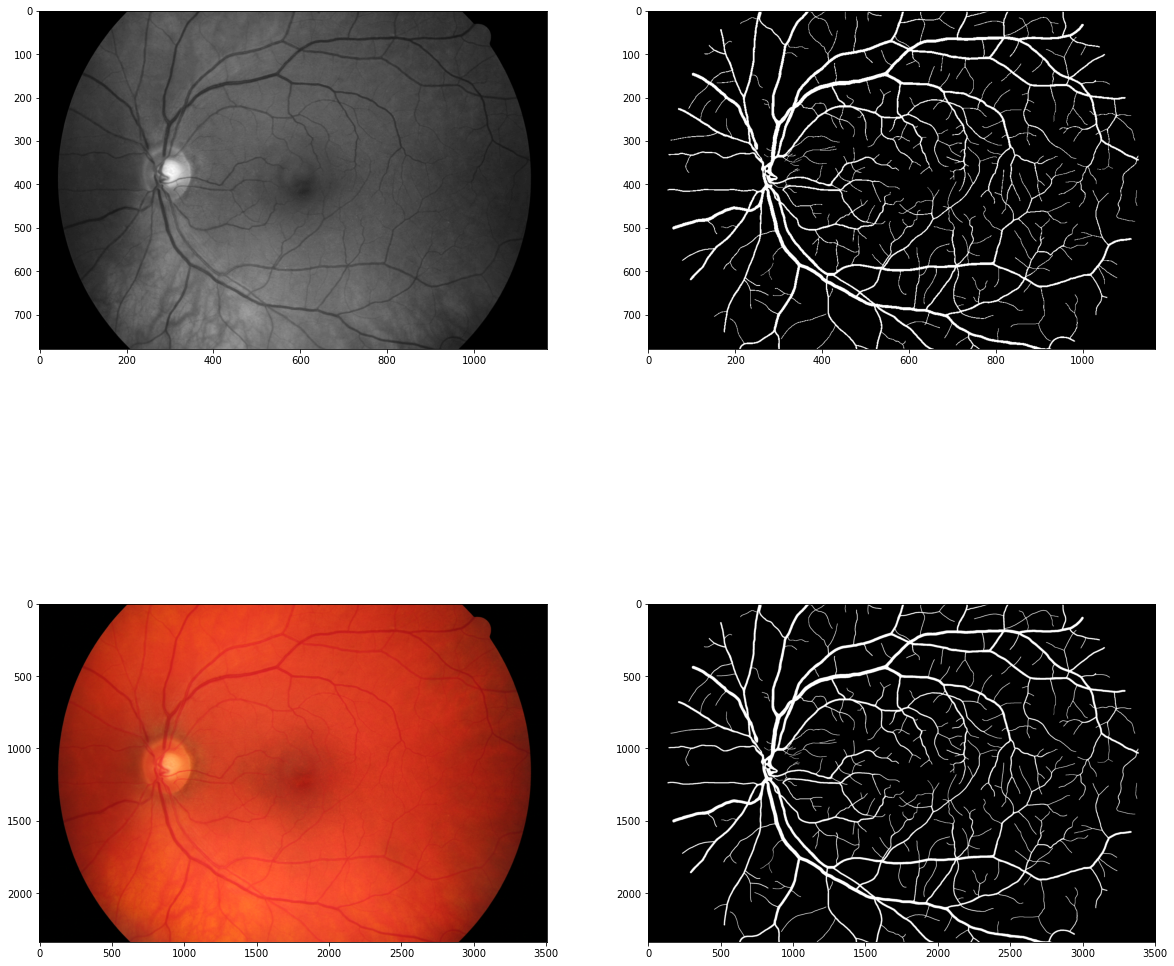

<IPython.core.display.Javascript object>

In [6]:
"""
#####            -----
#####            |   |
#####    ---->   | ? |
#####            |   |
#####            -----


"""


img2, mask2 = load_image(x_train_files[0]), load_mask(y_train_files[0])
img = image_loader.load_image(x_train_files[0])
mask = image_loader.load_mask(y_train_files[0])

print(f"{img.shape=}")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
ax1.imshow(img, cmap="gray")
ax2.imshow(mask, cmap="gray")
ax3.imshow(img2)
ax4.imshow(mask2, cmap="gray")
print(img.shape)

X.shape=(20, 15, 15) Y.shape=(20,) Y.sum()=2.0 Y.sum() / Y.size=0.1
np.prod(X.shape)=4500


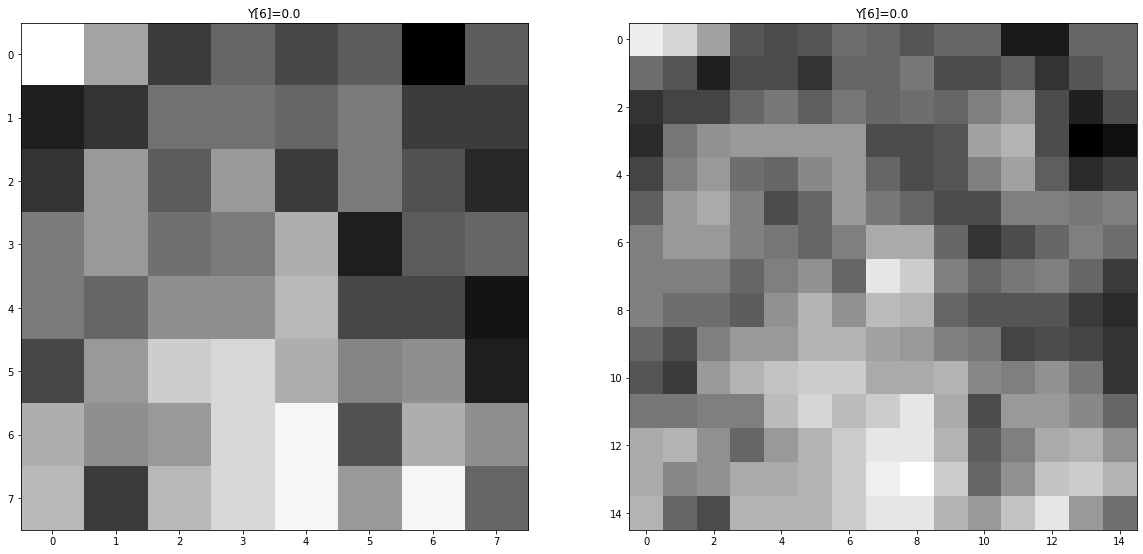

<IPython.core.display.Javascript object>

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
X, Y = ImagePatcher(patch_size=15, step=250, pixel_step=2).patch_image(img, mask)
ax1.imshow(X[6], cmap="gray")
ax1.set_title(f"{Y[6]=}")
X, Y = ImagePatcher(patch_size=15, step=250, pixel_step=1).patch_image(img, mask)
ax2.imshow(X[6], cmap="gray")
ax2.set_title(f"{Y[6]=}")
print(f"{X.shape=} {Y.shape=} {Y.sum()=} {Y.sum() / Y.size=}")
print(f"{np.prod(X.shape)=}")

In [7]:


# undersample = RandomUnderSampler(sampling_strategy="majority")
undersample = RandomUnderSampler(sampling_strategy=0.5)
oversample = RandomOverSampler(sampling_strategy=0.5)

X, Y = [], []
for path_x, path_y in tqdm.tqdm(zip(x_train_files, y_train_files), total=len(x_train_files)):
    img, mask = image_loader.load_image(path_x), image_loader.load_mask(path_y)
    x, y = image_patcher.patch_image(img, mask)
    x, y = examples_rotator.transform(x, y)
    x, y = feature_extractor.extract_and_flatten(x, y)
    x, y = undersample.fit_resample(x, y)
    # x, y = oversample.fit_resample(x, y)
    X.append(x)
    Y.append(y)



100%|██████████| 33/33 [07:10<00:00, 13.05s/it]


<IPython.core.display.Javascript object>

In [8]:
# X, Y = image_patcher.patch_image(img, mask)#

X_resampled, y_resampled = np.concatenate(X, axis=0), np.concatenate(Y, axis=0)
print(f"{X_resampled.shape=} {y_resampled.shape=}")

# X_resampled, y_resampled = RandomOverSampler().fit_resample(X_reshaped, Y_reshaped)
# X_resampled, y_resampled = SMOTE().fit_resample(X_reshaped, Y_reshaped)

# X_resampled, y_resampled = X_reshaped, Y_reshaped


print(sorted(Counter(y_resampled).items()))
print(f"{X_resampled.shape=} {y_resampled.shape=}")
X_resampled = X_resampled.astype("float32")

X_resampled.shape=(341916, 91) y_resampled.shape=(341916,)
[(0.0, 227944), (1.0, 113972)]
X_resampled.shape=(341916, 91) y_resampled.shape=(341916,)


<IPython.core.display.Javascript object>

In [9]:
# X_transformed = feature_transformation.transform(X_resampled)
X_transformed = X_resampled
y_transformed = y_resampled
pd.DataFrame(X_transformed[:, :15]).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000,341916.000000
mean,0.204647,0.203806,0.203041,0.202483,0.202254,0.202449,0.202993,0.203771,0.204622,0.203806,0.202697,0.201659,0.200891,0.200574,0.200853
std,0.105433,0.105178,0.104940,0.104765,0.104690,0.104730,0.104885,0.105109,0.105371,0.105193,0.104850,0.104523,0.104270,0.104157,0.104237
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.149020,0.149020,0.147746,0.146569,0.145982,0.146706,0.147794,0.149020,0.149020,0.149020,0.147129,0.145098,0.145098,0.145098,0.145098
50%,0.211765,0.211286,0.209519,0.208160,0.207843,0.207886,0.209321,0.210933,0.211765,0.211229,0.208757,0.207843,0.207843,0.207230,0.207843
75%,0.267963,0.266667,0.266667,0.266667,0.266619,0.266667,0.266667,0.266667,0.267847,0.266667,0.266667,0.265012,0.263690,0.262745,0.263417
max,0.960784,0.962730,0.968627,0.970573,0.976471,0.988235,0.980392,0.968627,0.962685,0.966601,0.968627,0.974490,0.978451,0.976471,0.984314


<IPython.core.display.Javascript object>

In [10]:
X_train, y_train = X_transformed, y_transformed

<IPython.core.display.Javascript object>

In [11]:
max_iter = 500
n_jobs = -1  # None = 1; -1 = all processors

# logistic_regression = LogisticRegressionCV(max_iter=max_iter, n_jobs=n_jobs)
logistic_regression = LogisticRegression(max_iter=max_iter, n_jobs=n_jobs)
random_forest = RandomForestClassifier(n_jobs=n_jobs)
kneighboors = KNeighborsClassifier(n_jobs=n_jobs)
decision_tree = DecisionTreeClassifier()
mlp = MLPClassifier(hidden_layer_sizes=(100, 100), random_state=0, max_iter=max_iter)

xgb_classifier = XGBClassifier(max_iter=max_iter, n_jobs=n_jobs)
svc = SVC()
linear_svc = LinearSVC()

random_forest2 = RandomForestClassifier(n_estimators=500)

classifiers = [
    logistic_regression,
    random_forest,
    random_forest2,
    # kneighboors,
    # decision_tree,
    mlp,
    xgb_classifier,
    # svc,
    # linear_svc,
]

estimators = [
    (
        type(classifier).__name__,
        make_pipeline(StandardScaler(), classifier),
    )
    for classifier in classifiers
]

models = [*estimators]

voting_estimators = [
    ("logistic_regression", logistic_regression),
    ("random_forest", random_forest2),
    ("mlp", mlp),
    ("xgb_classifier", xgb_classifier),
]

models.append(
    (
        "VotingClassifierHard",
        make_pipeline(
            StandardScaler(), VotingClassifier(voting_estimators, voting="hard")
        ),
    )
)
models.append(
    (
        "VotingClassifierSoft",
        make_pipeline(
            StandardScaler(), VotingClassifier(voting_estimators, voting="soft")
        ),
    )
)

# models = models[:-2]

# models.append(("DummyClassifierUniform", DummyClassifier(strategy="uniform")))
# models.append(("DummyClassifier0", DummyClassifier(strategy="constant", constant=0)))


def test_models():

    results = []
    names = []

    print(f"Testing models with {X_train.shape=} and {y_train.shape=}")

    for name, model in tqdm.tqdm(models):
        result = cross_val_score(
            model,
            X_transformed,
            y_transformed,
            cv=3,
            error_score="raise",
            n_jobs=n_jobs,
        )
        results.append(result)
        names.append(name)

    for i in range(len(results)):
        print(names[i], results[i].mean())

    mean_results = [r.mean() for r in results]
    idx = mean_results.index(max(mean_results))
    print(f"Best model {names[idx]} with mean result {mean_results[idx]}")

    """
    #most of models with highest score are already some sort of ensemble moddels...
    
    bagging = BaggingClassifier(
        clone_estimator(models[idx][1]),
        max_samples=0.5,
        max_features=0.5,
        n_jobs=n_jobs,
    )

    result = cross_val_score(
        bagging, X_resampled, y_resampled, cv=3, error_score="raise", n_jobs=n_jobs
    ).mean()

    new_name = "Bagging" + models[idx][0]
    print(f"{new_name} with mean score {result}")
    if result > mean_results[idx]:
        print(f"New best model {new_name} with mean score {result}")
        return new_name, bagging
    """

    return models[idx]


# best_model = test_models()

<IPython.core.display.Javascript object>

In [8]:
with open("model-na-4.pickle", "rb") as f:
    model = pickle.load(f)
print("Model loaded")

Model loaded


<IPython.core.display.Javascript object>

In [13]:
with open("train-zad-na-4.pickle", "wb") as f:
    pickle.dump([X_train, y_train], f)

<IPython.core.display.Javascript object>

In [14]:
with open("train-zad-na-4.pickle", "rb") as f:
    X_train, y_train = pickle.load(f)
print("X_train, y_train loaded")
print(f"{X_train.shape=} {y_train.shape=}")

X_train, y_train loaded
X_train.shape=(341916, 91) y_train.shape=(341916,)


<IPython.core.display.Javascript object>

In [15]:
try:
    raise FileNotFoundException
    with open("model-na-4.pickle", "rb") as f:
        model = pickle.load(f)
    print("Model loaded")
except Exception as e:
    print(e)
    print("Could not load model")
    try:
        name, model = models[6]
        name, model = best_model
        print(name)
    except NameError:
        print("Previous cell was not run. Using diffrent model")

        model = BaggingClassifier(
            clone_estimator(mlp),
            max_samples=0.5,
            max_features=0.5,
            n_jobs=n_jobs,
        )

        model = make_pipeline(StandardScaler(), xgb_classifier)
        model = make_pipeline(StandardScaler(), mlp)
        model = make_pipeline(
            StandardScaler(),
            VotingClassifier(
                voting_estimators, n_jobs=-1, voting="soft", verbose=False
            ),
        )
    print(f"{X_train.shape=} {y_train.shape=}")
    model.fit(X_train, y_train)
    with open("model-na-4.pickle", "wb") as f:
        pickle.dump(model, f)
print(model)

name 'FileNotFoundException' is not defined
Could not load model
Previous cell was not run. Using diffrent model
X_train.shape=(341916, 91) y_train.shape=(341916,)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('votingclassifier',
                 VotingClassifier(estimators=[('logistic_regression',
                                               LogisticRegression(max_iter=500,
                                                                  n_jobs=-1)),
                                              ('random_forest',
                                               RandomForestClassifier(n_estimators=500)),
                                              ('mlp',
                                               MLPClassifier(hidden_layer_sizes=(100,
                                                                                 100),
                                                             max_iter=500,
                                                            

<IPython.core.display.Javascript object>

In [16]:
img = image_loader.load_image(x_test_files[0])
mask = image_loader.load_mask(y_test_files[0])
fov = image_loader.load_mask(fov_test_files[0])

min_d = min(img.shape[:2])
slice_r = slice(img.shape[0]//4, img.shape[0]*3//4)
slice_c = slice(img.shape[1]//4, img.shape[1]*3//4)

slice_r = slice(img.shape[0]//2, img.shape[0]//2 + 100)
slice_c = slice(img.shape[1]//2, img.shape[1]//2 + 100)

img = img[slice_r, slice_c]
mask = mask[slice_r, slice_c]
fov = fov[slice_r, slice_c]

print(f"{img.shape=}")
pred = predict_image(model, img)
print(f"{pred.min()=} {pred.max()=} {pred.shape=} {pred.sum()=} {(pred == 0).sum() + pred.sum() - pred.size}")


img.shape=(100, 100, 1)
pred.min()=0.0 pred.max()=1.0 pred.shape=(91, 91) pred.sum()=862.0 0.0


<IPython.core.display.Javascript object>

In [10]:
hps = patch_size // 2
cut_mask = mask[hps : -hps - 1, hps : -hps - 1]
cut_fov = fov[hps : -hps - 1, hps : -hps - 1]

pred_erosion = pred * binary_erosion(cut_fov, disk(5))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15))
for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.axis("off")
ax1.imshow(mask, cmap="gray")
ax2.imshow(pred_erosion, cmap="gray")
fig.tight_layout()



NameError: name 'mask' is not defined

<IPython.core.display.Javascript object>

In [9]:
from sklearn.metrics import classification_report, confusion_matrix


<IPython.core.display.Javascript object>

In [18]:

print(classification_report(pred_erosion.flatten(), cut_mask.flatten()))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      7419
         1.0       0.70      0.21      0.33       862

    accuracy                           0.91      8281
   macro avg       0.81      0.60      0.64      8281
weighted avg       0.89      0.91      0.89      8281



<IPython.core.display.Javascript object>

float64 1.0
              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96      7504
         1.0       0.68      0.23      0.35       777

    accuracy                           0.92      8281
   macro avg       0.80      0.61      0.65      8281
weighted avg       0.90      0.92      0.90      8281



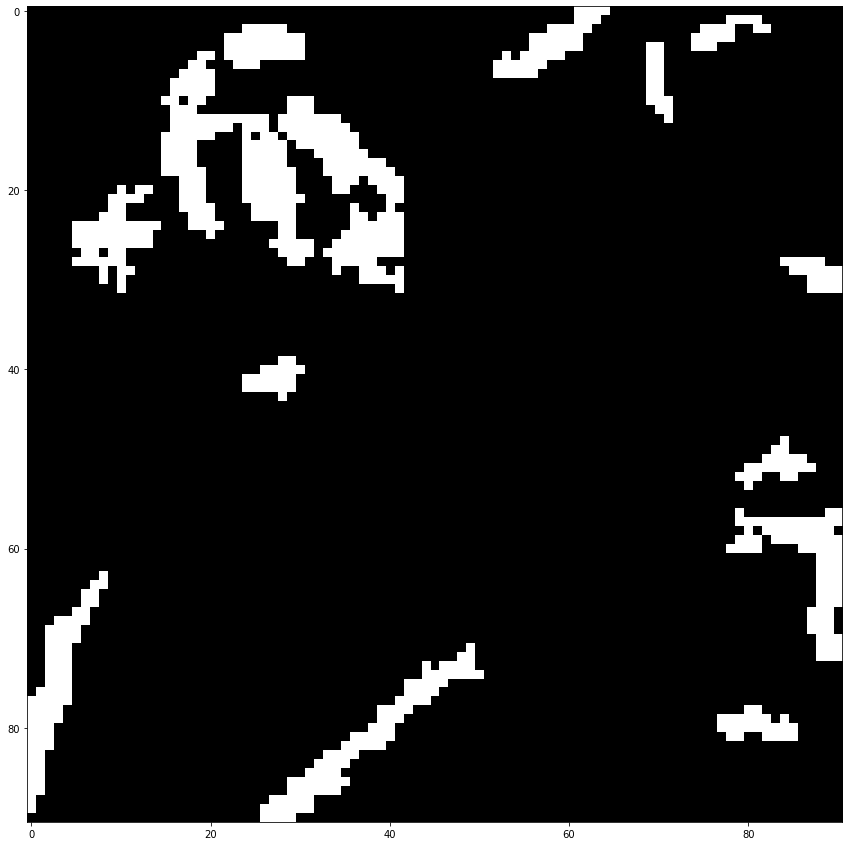

<IPython.core.display.Javascript object>

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
pred_changed = pred_erosion  # * cut_mask
# pred_changed = skimage.filters.median(pred_changed)
print(pred_changed.dtype, pred_changed.max())
pred_changed = 1 - skimage.morphology.area_closing(1 - pred_changed, area_threshold=15)
ax.imshow(pred_changed, cmap="gray")
print(classification_report(pred_changed.flatten(), cut_mask.flatten()))

In [20]:
all_predictions = []
all_y = []
for img_path, mask_path, fov_path in tqdm.tzip(x_test_files, y_test_files, fov_test_files):
    img = image_loader.load_image(img_path)
    mask = image_loader.load_mask(mask_path)
    fov = image_loader.load_mask(fov_path)

    pred = predict_image(model, img)

    hps = patch_size // 2
    cut_mask = mask[hps : -hps - 1, hps : -hps - 1]
    cut_fov = fov[hps : -hps - 1, hps : -hps - 1]

    pred_erosion = pred * binary_erosion(cut_fov, disk(5))
    
    all_predictions.append(pred_erosion)
    all_y.append(cut_mask)

    


6it [24:05, 240.93s/it]


<IPython.core.display.Javascript object>

In [21]:
print(len(all_predictions))

6


<IPython.core.display.Javascript object>

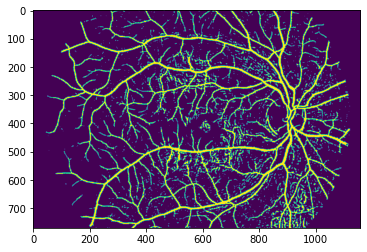

<IPython.core.display.Javascript object>

In [22]:
plt.imshow(all_predictions[0])

<IPython.core.display.Javascript object>

In [10]:
with open("predictions_and_y-na-4.pickle", "rb") as f:
    all_predictions2, all_y2 = pickle.load(f)

<IPython.core.display.Javascript object>

In [40]:
from PIL import Image


try:
    os.mkdir("predictions_na_4")
except:
    pass
for name, mask, pred in zip(x_test_files, y_test_files, all_predictions2):
    file_name = name.split("/")[-1].split(".")[0]
    mask_name = mask.split("/")[-1].split(".")[0]
    print(name)
    im = Image.fromarray(np.uint8(pred * 255))
    im.save(f"predictions_na_4/{file_name}.png")
    img = imread(mask, as_gray=True)
    img = transform.rescale(img, 1 / 3, mode="reflect")
    im = Image.fromarray(np.uint8(img * 255))
    im.save(f"predictions_na_4/{file_name}-original.png")

    image = load_image(name, gray=False)
    image = rgb_rescale(image, 1 / 3, mode="reflect")
    image = image[hps : -hps - 1, hps : -hps - 1]
    image[pred == 1] = np.array([0, 1, 0])
    image = np.clip(image, 0, 1)
    im = Image.fromarray(np.uint8(image * 255))
    im.save(f"predictions_na_4/{file_name}-masked.png")

/home/maciej/.keras/datasets/images/03_h.jpg
/home/maciej/.keras/datasets/images/15_g.jpg
/home/maciej/.keras/datasets/images/13_g.jpg
/home/maciej/.keras/datasets/images/01_g.jpg
/home/maciej/.keras/datasets/images/07_dr.JPG
/home/maciej/.keras/datasets/images/05_h.jpg


<IPython.core.display.Javascript object>

In [13]:

hps = patch_size // 2
predictions_masked = []
y_masked = []
for p, y, fov_file in zip(all_predictions2, all_y2, sorted(fov_test_files)):
    fov = load_image(fov_file, gray=True, rescale=1 / 3)
    fov = fov[hps : -hps - 1, hps : -hps - 1]
    fov = np.round(fov).astype("uint8")
    predictions_masked.append(p[fov == 1])
    y_masked.append(y[fov == 1])

    print(fov_file)
    print(classification_report(y_masked[-1], predictions_masked[-1]))

from sklearn.metrics import classification_report, confusion_matrix

#all predictions - binarny wynik predykcji
#all_y - co powinno wyjść (pliki z manual1)

predictions_flat = np.concatenate([p.flatten() for p in all_predictions2])
masks_flat = np.concatenate([m.flatten() for m in all_y2])
print(classification_report(masks_flat, predictions_flat))
print(np.sum(confusion_matrix(masks_flat, predictions_flat)))

/home/maciej/.keras/datasets/mask/01_g_mask.tif
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.95    666283
         1.0       0.63      0.88      0.73     95473

    accuracy                           0.92    761756
   macro avg       0.80      0.90      0.84    761756
weighted avg       0.94      0.92      0.92    761756

/home/maciej/.keras/datasets/mask/03_h_mask.tif
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    695269
         1.0       0.65      0.83      0.73     66230

    accuracy                           0.95    761499
   macro avg       0.82      0.89      0.85    761499
weighted avg       0.95      0.95      0.95    761499

/home/maciej/.keras/datasets/mask/05_h_mask.tif
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    699931
         1.0       0.60      0.85      0.70     61574

    accuracy                          

NameError: name 'all_predictions' is not defined

<IPython.core.display.Javascript object>

In [23]:
cm = confusion_matrix(masks_flat, predictions_flat)
print(cm)
print(cm.sum(axis=0))
print(cm.sum(axis=1))
print(np.sum(confusion_matrix(masks_flat, predictions_flat)))

[[3928435  206649]
 [  62862  372137]]
[3991297  578786]
[4135084  434999]
4570083


<IPython.core.display.Javascript object>

In [26]:
"""
patch_size = 9  # >= 4
pixel_step = 1
image_loader = ImageLoader(
    gray=False, rescale=1 / 3, channels=[1]
)  # channels are ignored if gray=True
image_patcher = ImagePatcher(patch_size=patch_size, step=patch_size, pixel_step=pixel_step)
feature_extractor = FeatureExtractor(features=[("hu", {"channels": [0]}), ("glcm",)])
voting soft
undersample(0.25)
hu[0] glcm green_channel 
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98   4919528
         1.0       0.73      0.79      0.76    435052

    accuracy                           0.96   5354580
   macro avg       0.86      0.88      0.87   5354580
weighted avg       0.96      0.96      0.96   5354580


patch_size = 9  # >= 4
pixel_step = 1
image_loader = ImageLoader(
    gray=False, rescale=1 / 3, channels=[1]
)  # channels are ignored if gray=True
image_patcher = ImagePatcher(patch_size=patch_size, step=25, pixel_step=pixel_step)
feature_extractor = FeatureExtractor(features=[("hu", {"channels": [0]}), ("glcm",)])
mlp
hu[0] glcm green_channel ALL DATA
            precision    recall  f1-score   support

         0.0       0.99      0.97      0.98    843507
         1.0       0.64      0.91      0.75     48923

    accuracy                           0.97    892430
   macro avg       0.82      0.94      0.87    892430
weighted avg       0.98      0.97      0.97    892430

same but voting_classifier_soft(lr, mlp, rf, xgb)
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98    847104
         1.0       0.60      0.93      0.73     45326

    accuracy                           0.97    892430
   macro avg       0.80      0.95      0.86    892430
weighted avg       0.98      0.97      0.97    892430


"""

'\npatch_size = 9  # >= 4\npixel_step = 1\nimage_loader = ImageLoader(\n    gray=False, rescale=1 / 3, channels=[1]\n)  # channels are ignored if gray=True\nimage_patcher = ImagePatcher(patch_size=patch_size, step=patch_size, pixel_step=pixel_step)\nfeature_extractor = FeatureExtractor(features=[("hu", {"channels": [0]}), ("glcm",)])\nvoting soft\nundersample(0.25)\nhu[0] glcm green_channel \n              precision    recall  f1-score   support\n\n         0.0       0.98      0.97      0.98   4919528\n         1.0       0.73      0.79      0.76    435052\n\n    accuracy                           0.96   5354580\n   macro avg       0.86      0.88      0.87   5354580\nweighted avg       0.96      0.96      0.96   5354580\n\n\npatch_size = 9  # >= 4\npixel_step = 1\nimage_loader = ImageLoader(\n    gray=False, rescale=1 / 3, channels=[1]\n)  # channels are ignored if gray=True\nimage_patcher = ImagePatcher(patch_size=patch_size, step=25, pixel_step=pixel_step)\nfeature_extractor = Feature

<IPython.core.display.Javascript object>

In [27]:
(0.98 * 0.73) ** 0.5

0.84581321815162

<IPython.core.display.Javascript object>